# COVID-19 Time series Data Analysis

In [75]:
import pandas as pd
import numpy as np   
import tensorflow as tf
from statsmodels.tools.eval_measures import rmse 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import math
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.grid'] = True

In [76]:
covid_data=pd.read_csv('COVID-19 Cases.csv',parse_dates = ['Date'],index_col=['Date']).sort_index(axis=0)

In [77]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 633240 entries, 2020-01-22 to 2020-04-20
Data columns (total 17 columns):
Case_Type                               633240 non-null object
Cases                                   633240 non-null int64
Difference                              633240 non-null int64
Combined_Key                            633240 non-null object
Country_Region                          633240 non-null object
Province_State                          600840 non-null object
Admin2                                  585720 non-null object
iso2                                    632880 non-null object
iso3                                    633060 non-null object
FIPS                                    566460 non-null float64
Lat                                     614340 non-null float64
Long                                    614340 non-null float64
Population_Count                        614340 non-null float64
People_Total_Tested_Count               1008 non-nul

In [78]:
covid_data.head(5)

Case_Type  Cases  Difference                Combined_Key  \
Date                                                                   
2020-01-22  Confirmed      0           0        Bullock, Alabama, US   
2020-01-22  Confirmed      0           0  Walworth, South Dakota, US   
2020-01-22     Deaths      0           0          Owen, Kentucky, US   
2020-01-22  Confirmed      0           0    Webster, Mississippi, US   
2020-01-22     Deaths      0           0      Onondaga, New York, US   

           Country_Region Province_State    Admin2 iso2 iso3     FIPS  \
Date                                                                    
2020-01-22             US        Alabama   Bullock   US  USA   1011.0   
2020-01-22             US   South Dakota  Walworth   US  USA  46129.0   
2020-01-22             US       Kentucky      Owen   US  USA  21187.0   
2020-01-22             US    Mississippi   Webster   US  USA  28155.0   
2020-01-22             US       New York  Onondaga   US  USA  36067.0   

                  Lat        Long  Population_Count  \
Date                                                  
2020-01-22  32.100305  -85.712655           10101.0   
2020-01-22  45.430196 -100.030751            5435.0   
2020-01-22  38.516791  -84.824046           10901.0   
2020-01-22  33.613005  -89.283929            9689.0   
2020-01-22  43.004919  -76.199712          460528.0   

            People_Total_Tested_Count  People_Hospitalized_Cumulative_Count  \
Date                                                                          
2020-01-22                        NaN                                   NaN   
2020-01-22                        NaN                                   NaN   
2020-01-22                        NaN                                   NaN   
2020-01-22                        NaN                                   NaN   
2020-01-22                        NaN                                   NaN   

                                                  Data_Source  \
Date                                                            
2020-01-22  2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...   
2020-01-22  2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...   
2020-01-22  2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...   
2020-01-22  2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...   
2020-01-22  2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...   

               Prep_Flow_Runtime  
Date                              
2020-01-22  4/20/2020 8:12:12 PM  
2020-01-22  4/20/2020 8:12:12 PM  
2020-01-22  4/20/2020 8:12:12 PM  
2020-01-22  4/20/2020 8:12:12 PM  
2020-01-22  4/20/2020 8:12:12 PM

In [79]:
covid_data.corr()

Cases  Difference      FIPS  \
Cases                                 1.000000    0.736335 -0.000306   
Difference                            0.736335    1.000000 -0.001067   
FIPS                                 -0.000306   -0.001067  1.000000   
Lat                                   0.006848    0.009567  0.074996   
Long                                  0.082014    0.072992  0.087786   
Population_Count                      0.066153    0.076076 -0.052951   
People_Total_Tested_Count             0.093440   -0.016317  0.266792   
People_Hospitalized_Cumulative_Count  0.097137   -0.006946 -0.202288   

                                           Lat      Long  Population_Count  \
Cases                                 0.006848  0.082014          0.066153   
Difference                            0.009567  0.072992          0.076076   
FIPS                                  0.074996  0.087786         -0.052951   
Lat                                   1.000000 -0.462258         -0.131254   
Long                                 -0.462258  1.000000          0.296637   
Population_Count                     -0.131254  0.296637          1.000000   
People_Total_Tested_Count             0.370647 -0.199772          0.985271   
People_Hospitalized_Cumulative_Count  0.133323  0.524459         -0.209961   

                                      People_Total_Tested_Count  \
Cases                                                  0.093440   
Difference                                            -0.016317   
FIPS                                                   0.266792   
Lat                                                    0.370647   
Long                                                  -0.199772   
Population_Count                                       0.985271   
People_Total_Tested_Count                              1.000000   
People_Hospitalized_Cumulative_Count                   0.861366   

                                      People_Hospitalized_Cumulative_Count  
Cases                                                             0.097137  
Difference                                                       -0.006946  
FIPS                                                             -0.202288  
Lat                                                               0.133323  
Long                                                              0.524459  
Population_Count                                                 -0.209961  
People_Total_Tested_Count                                         0.861366  
People_Hospitalized_Cumulative_Count                              1.000000

In [80]:
covid_data.shape

(633240, 17)

In [81]:
covid_data[(covid_data['Country_Region']=='US')&(covid_data['Admin2']=='Bullock')&(covid_data['Case_Type']=='Confirmed')].corr()

Cases    Difference  FIPS  \
Cases                                 1.000000e+00  5.261524e-01   NaN   
Difference                            5.261524e-01  1.000000e+00   NaN   
FIPS                                           NaN           NaN   NaN   
Lat                                   5.643986e-16  1.810660e-16   NaN   
Long                                 -8.418506e-16 -1.448528e-16   NaN   
Population_Count                               NaN           NaN   NaN   
People_Total_Tested_Count                      NaN           NaN   NaN   
People_Hospitalized_Cumulative_Count           NaN           NaN   NaN   

                                               Lat          Long  \
Cases                                 5.643986e-16 -8.418506e-16   
Difference                            1.810660e-16 -1.448528e-16   
FIPS                                           NaN           NaN   
Lat                                   1.000000e+00 -1.000000e+00   
Long                                 -1.000000e+00  1.000000e+00   
Population_Count                               NaN           NaN   
People_Total_Tested_Count                      NaN           NaN   
People_Hospitalized_Cumulative_Count           NaN           NaN   

                                      Population_Count  \
Cases                                              NaN   
Difference                                         NaN   
FIPS                                               NaN   
Lat                                                NaN   
Long                                               NaN   
Population_Count                                   NaN   
People_Total_Tested_Count                          NaN   
People_Hospitalized_Cumulative_Count               NaN   

                                      People_Total_Tested_Count  \
Cases                                                       NaN   
Difference                                                  NaN   
FIPS                                                        NaN   
Lat                                                         NaN   
Long                                                        NaN   
Population_Count                                            NaN   
People_Total_Tested_Count                                   NaN   
People_Hospitalized_Cumulative_Count                        NaN   

                                      People_Hospitalized_Cumulative_Count  
Cases                                                                  NaN  
Difference                                                             NaN  
FIPS                                                                   NaN  
Lat                                                                    NaN  
Long                                                                   NaN  
Population_Count                                                       NaN  
People_Total_Tested_Count                                              NaN  
People_Hospitalized_Cumulative_Count                                   NaN

In [82]:
covid_data[(covid_data['Country_Region']=='US')&(covid_data['Case_Type']=='Confirmed')].corr()

Cases  Difference      FIPS  \
Cases                                 1.000000    0.860513 -0.000463   
Difference                            0.860513    1.000000 -0.001571   
FIPS                                 -0.000463   -0.001571  1.000000   
Lat                                   0.005972    0.006883  0.074996   
Long                                  0.028554    0.035280  0.087786   
Population_Count                      0.281543    0.325575 -0.052951   
People_Total_Tested_Count             0.047849   -0.017243  0.266792   
People_Hospitalized_Cumulative_Count  0.025963   -0.008472 -0.202288   

                                           Lat      Long  Population_Count  \
Cases                                 0.005972  0.028554          0.281543   
Difference                            0.006883  0.035280          0.325575   
FIPS                                  0.074996  0.087786         -0.052951   
Lat                                   1.000000 -0.290030         -0.061303   
Long                                 -0.290030  1.000000          0.010166   
Population_Count                     -0.061303  0.010166          1.000000   
People_Total_Tested_Count             0.370647 -0.199772          0.985271   
People_Hospitalized_Cumulative_Count  0.133323  0.524459         -0.209961   

                                      People_Total_Tested_Count  \
Cases                                                  0.047849   
Difference                                            -0.017243   
FIPS                                                   0.266792   
Lat                                                    0.370647   
Long                                                  -0.199772   
Population_Count                                       0.985271   
People_Total_Tested_Count                              1.000000   
People_Hospitalized_Cumulative_Count                   0.861366   

                                      People_Hospitalized_Cumulative_Count  
Cases                                                             0.025963  
Difference                                                       -0.008472  
FIPS                                                             -0.202288  
Lat                                                               0.133323  
Long                                                              0.524459  
Population_Count                                                 -0.209961  
People_Total_Tested_Count                                         0.861366  
People_Hospitalized_Cumulative_Count                              1.000000

In [83]:
covid_data[(covid_data['Country_Region']=='US')&(covid_data['Case_Type']=='Confirmed')].describe()

Cases     Difference           FIPS            Lat  \
count  293310.000000  293310.000000  283230.000000  283950.000000   
mean       38.058007       2.673533   30335.484906      38.414583   
std       932.890670      54.898376   15196.115165       5.437648   
min         0.000000   -1314.000000      60.000000     -14.271000   
25%         0.000000       0.000000   18169.000000      34.688358   
50%         0.000000       0.000000   29171.000000      38.384828   
75%         1.000000       0.000000   45079.000000      41.792284   
max    141235.000000    8220.000000   56045.000000      69.314792   

                Long  Population_Count  People_Total_Tested_Count  \
count  283950.000000      2.839500e+05                 504.000000   
mean      -92.155938      1.076612e+05               60650.003968   
std        14.271230      3.661183e+05               85624.473857   
min      -170.132000      8.600000e+01                   3.000000   
25%       -98.313190      1.093900e+04               13350.000000   
50%       -90.404212      2.603200e+04               34905.500000   
75%       -83.430787      6.906900e+04               67903.000000   
max       145.673900      1.003911e+07              633861.000000   

       People_Hospitalized_Cumulative_Count  
count                            504.000000  
mean                            1900.807540  
std                             6668.908734  
min                                0.000000  
25%                               55.000000  
50%                              395.500000  
75%                             1494.750000  
max                            57103.000000

In [84]:
df_groupby=covid_data[(covid_data['Case_Type']=='Confirmed')&(covid_data['Country_Region']=='US')].groupby(['Date','Country_Region'])[['Population_Count','Difference']].sum()

In [85]:
df_groupby

Population_Count  Difference
Date       Country_Region                              
2020-01-22 US                   339671000.0           1
2020-01-23 US                   339671000.0           0
2020-01-24 US                   339671000.0           1
2020-01-25 US                   339671000.0           0
2020-01-26 US                   339671000.0           3
...                                     ...         ...
2020-04-16 US                   339671000.0       31242
2020-04-17 US                   339671000.0       32114
2020-04-18 US                   339671000.0       32491
2020-04-19 US                   339671000.0       26889
2020-04-20 US                   339671000.0       25240

[90 rows x 2 columns]

In [86]:
df_groupby_US=covid_data[(covid_data['Case_Type']=='Confirmed')&(covid_data['Country_Region']=='US')].groupby(['Date'])[['Difference']].sum()

In [87]:
df_groupby_US

Difference
Date                  
2020-01-22           1
2020-01-23           0
2020-01-24           1
2020-01-25           0
2020-01-26           3
...                ...
2020-04-16       31242
2020-04-17       32114
2020-04-18       32491
2020-04-19       26889
2020-04-20       25240

[90 rows x 1 columns]

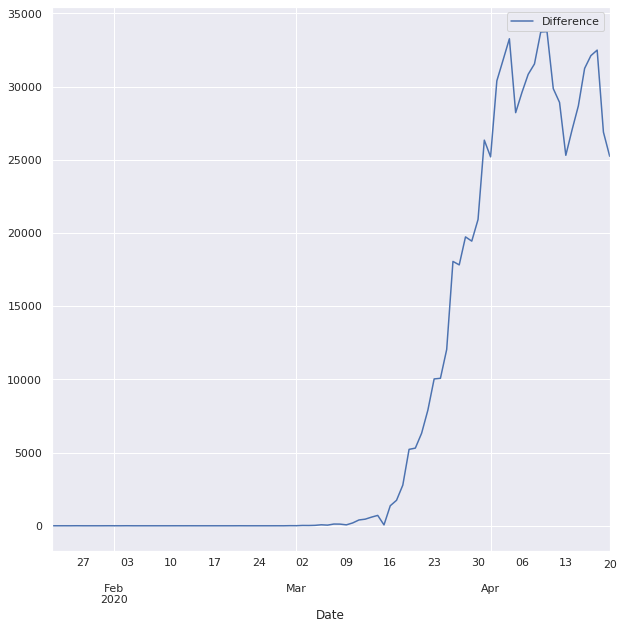

In [88]:
df_groupby_US.plot()

In [89]:
len(df_groupby_US)

90

In [90]:
train, test = df_groupby_US[:-27], df_groupby_US[-27:]

In [91]:
len(test)

27

In [92]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [ ]:
n_input = 27
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=600)

In [94]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)

In [95]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df_groupby_US[-n_input:].index, columns=['Predictions'])
df_test = pd.concat([df_groupby_US, df_predict], axis=1)

In [96]:
df_test.tail(20)

Difference  Predictions
Date                               
2020-04-01       25200  1074.055446
2020-04-02       30390   748.614962
2020-04-03       31824   540.313136
2020-04-04       33267   403.783775
2020-04-05       28219   316.220178
2020-04-06       29595   260.781604
2020-04-07       30838   220.049693
2020-04-08       31547   183.164699
2020-04-09       33728   149.880908
2020-04-10       33755   116.453041
2020-04-11       29861    85.044254
2020-04-12       28917    72.241226
2020-04-13       25306    46.127496
2020-04-14       27051    24.377643
2020-04-15       28680     1.790348
2020-04-16       31242   -26.737318
2020-04-17       32114   -42.661663
2020-04-18       32491   -48.716635
2020-04-19       26889   -40.412199
2020-04-20       25240   -17.430405

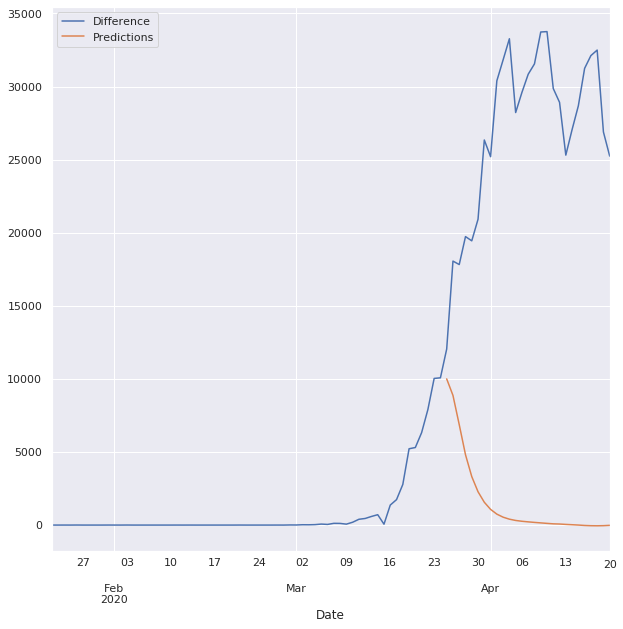

In [97]:
df_test.plot()